In [1]:
import numpy as np
import petl
import scipy
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')
import h5py
import allel
import itertools
import scipy.stats as stats
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Estimating signals of selection and genetic diversity within PNG
Date Updated: 05-07-16
Author: Stuart Lee

Recently we constructed a new pipeline for aligning high-throughput sequencing data according to the Malaria Genomics Pf3k specifications. We have now applied this to the Papua New Guinea samples - for details please see the [processing report](report.html) and the [pipeline code and specifications](https://github.com/bahlolab/pf_variant_calling_pipeline).

After running the pipeline, we obtain a set of biallelic single nucleotide polymorphisms (SNPs) and estimates of multiplicity of infection using our R package [moimix](https://github.com/bahlolab/moimix) and the $F_{ws}$ metric. Post pipeline filtering of multiple clone infections and low-quality samples we were left with slightly over 100 samples. 

Here we run a simple selection pipeline using the final variant calls from our pipeline. 

First we investigate population structure and differential selection between our three sampling sites - Madang, Alotau, and Maprik - using multidimensional scaling, PCA, and  $F_{st}$ statistic using the [Hudson estimator](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC1205159/). For our analysis of admixture in PNG please see our follow up [report](png_structure.html).

Next we investigate signals of selection by computing linkage disequilbrium decay, Tajima's $D$, the integrated haplotype score (iHS) and the number of segregating loci statistic (nSL) accross the three sampling sites. We collate the putative SNPs under selection

We also extract data for admixture/structure analysis using B-allele frequencies to construct major haplotypes genome-wide for each isolate. Here we construct two sets of markers for analysis:

1. Full SNP set 
2. LD filtered SNP set (SNPs with $r^2$ < 0.1)

Finally, we follow-up on signals of selection in known resitance loci including _pfcrt_, _dhps_, _dhfr_, _pfmdr_ and _kelch13_ and produce bifurication plots to see the different selection pressures on these loci within PNG. 

## Population Structure

We extract the final sample counts within each sampling site and the genotypes across all chromosomes. 

In [2]:
# read sample metadata 
sample_metadata = "samples_meta.txt"
cohort_all = pd.read_table(sample_metadata, sep = " ", names = ["sample_id", "site"])
# extract MOI = 1 samples 
png_sc_isolates = pd.read_table("cache/png_summary_samples.txt", names = ["sample_id"])
cohort_final = pd.merge(cohort_all, png_sc_isolates, on=['sample_id'])

print cohort_final.site.value_counts()

# set up dictionary mapping to samples
# set up map
png_index = {}

png_index['all'] =  list(range(len(cohort_final)))

for pop in cohort_final.site.unique():
    # put everything to lower case
    pop1 = pop.lower()
    png_index[pop1] = cohort_final[cohort_final.site == pop].index

png_index

# read h5 file 
chromosomes= ['Pf3D7_01_v3', 'Pf3D7_02_v3', 'Pf3D7_03_v3', 
         'Pf3D7_04_v3', 'Pf3D7_05_v3', 'Pf3D7_06_v3', 
         'Pf3D7_07_v3','Pf3D7_08_v3', 'Pf3D7_09_v3', 
         'Pf3D7_10_v3', 'Pf3D7_11_v3', 'Pf3D7_12_v3', 
         'Pf3D7_13_v3', 'Pf3D7_14_v3']

png_variants = h5py.File("cache/png_final.h5", mode = 'r')

# extract variant metadata
# extract genotypes
png_calls = [allel.GenotypeChunkedArray(png_variants[chrom]['calldata']['genotype']) for chrom in chromosomes]

# extract variant calls metadata
metadata = ["CHROM", "POS", "ANN"]
png_vmeta = [allel.VariantChunkedTable(png_variants[chrom]['variants'], 
                                      names = metadata, index='POS') for chrom in chromosomes]

Madang    44
Maprik    36
Alotau    21
Name: site, dtype: int64


To perform principal coordinates analysis over the entire SNP set, we flatten genotypes into a single haplotype array containing all genotype calls per sample. Then we compute the city block distance between samples to construct the principle coordinates. We plot the principal coordinates for dimensions 1,2,3 and their respective proprotion of variance each axis explains. 

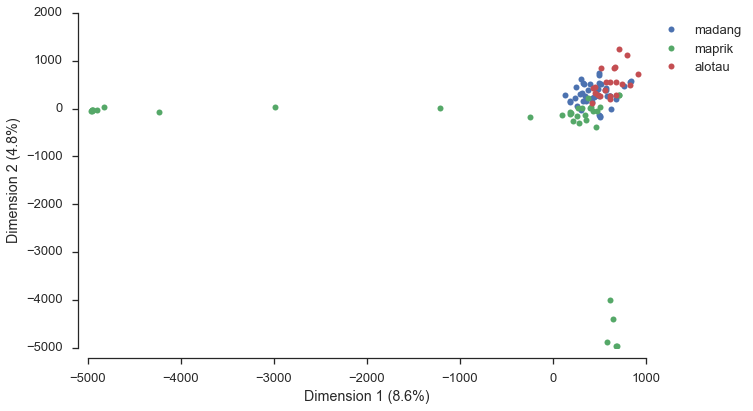

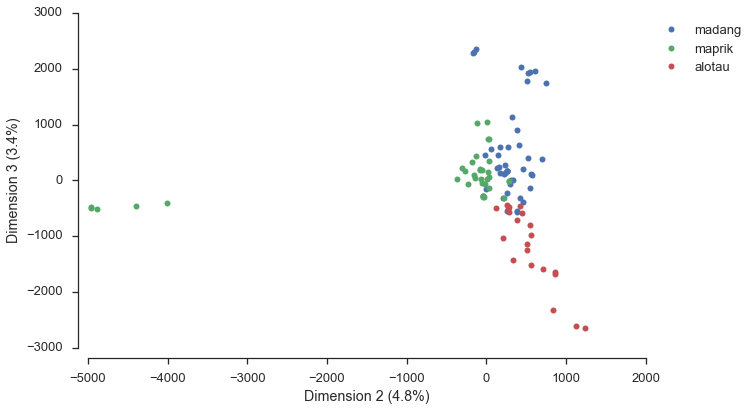

In [4]:
# convert to GT calls using haplotype array
gt = allel.GenotypeArray(allel.chunked.core.vstack(png_calls))

# compute cityblock distance
d = allel.stats.pairwise_distance(gt.to_n_alt()[:], metric='cityblock')

coords, variance = allel.stats.pcoa(d)

def plot_mds(coords, variance, population_dict, x, y, ax):
    a = coords[:, x]
    b = coords[:, y]
    pops = [key for key in population_dict.keys() if key != 'all']
    for pop in pops:
        flt = population_dict[pop]
        ax.plot(a[flt], b[flt], marker='o', linestyle=' ', label=pop, markersize=6)
    ax.set_xlabel('Dimension %s (%.1f%%)' % (x+1, variance[x]*100))
    ax.set_ylabel('Dimension %s (%.1f%%)' % (y+1, variance[y]*100))
    
fig, ax = plt.subplots(figsize=(10, 6))
sns.despine(ax=ax, offset=10)
plot_mds(coords, variance, png_index, 0, 1, ax)
ax.legend( bbox_to_anchor=(1, 1), loc='upper left');

fig, ax = plt.subplots(figsize = (10, 6))
sns.despine(ax = ax, offset=10)
plot_mds(coords, variance, png_index, 1,2, ax)
ax.legend( bbox_to_anchor=(1, 1), loc='upper left');

There appears to be a few outlier samples from Madang that appear to be driving the principal coordinates in dimension 1. We also see that dimension 2 appears to capture the geographical differences present in the data. 

We now estimate the average genome-wide $F_{st}$ overall between the three populations using the Hudson estimator with a bootstrapped estimate of the standard error. To begin we count the number of segregating sites per chromosome and then find SNPs that are segregating in the union of all three sites.

In [5]:
ac_subpops = [png_calls[i].count_alleles_subpops(png_index, max_allele=1) for i in range(len(png_calls))]

is_seg = [ac_subpops[i]['all'].is_segregating()[:] for i in range(len(ac_subpops))]
# subset calls
ac_seg = [ac_subpops[i].compress(is_seg[i]) for i in range(len(is_seg))]

variants_seg = [png_vmeta[i].compress(is_seg[i]) for i in range(len(is_seg)) ]

genotypes_seg = [png_calls[i].compress(is_seg[i], axis=0) for i in range(len(is_seg))]

positions = [variants_seg[i]["POS"][:] for i in range(len(variants_seg))]

# extract b-allele counts
acounts = [png_variants[chrom]['calldata']['AD'].compress(is_seg[i], axis = 0) for chrom in chromosomes]


# merge into single chromosome
#ac_subpops_merged = allel.AlleleCountsArray(allel.chunked.core.hstack(ac_seg))
gt_subpops_merged = allel.GenotypeChunkedArray(allel.chunked.core.vstack(genotypes_seg))
ac_subpops_merged = gt_subpops_merged.count_alleles_subpops(png_index, max_allele = 1)


for pop in png_index.keys():
    print "# " + pop + " segregating allele counts:", ac_subpops_merged[pop].count_segregating()

# avg Fst genome wide
sites = [key for key in png_index.keys() if key != 'all']
site_combos = itertools.combinations(sites, 2)
for pairs in site_combos:
    fst_hudson, se_hudson, vb_hudson, _ = allel.stats.blockwise_hudson_fst(ac_subpops_merged[pairs[0]], 
                                                                           ac_subpops_merged[pairs[1]], blen=1000)
    print 'Fst between %s and %s %.04f +/- %.04f (Hudson)' % (pairs[0], pairs[1], fst_hudson, se_hudson)



# all segregating allele counts: 25362
# madang segregating allele counts: 20003
# maprik segregating allele counts: 17414
# alotau segregating allele counts: 14729
Fst between madang and maprik 0.0557 +/- 0.0012 (Hudson)
Fst between madang and alotau 0.0476 +/- 0.0020 (Hudson)
Fst between maprik and alotau 0.0821 +/- 0.0026 (Hudson)


Next we construct the PCA estimates based on the segregating major haplotypes estimated above. First we downsample the number of variants to find those that are in approximate linkage equilibrium ($r^2 < 0.1$) and that have a minor allele count > 2. 

Variants in linkage equilibrium: 6435


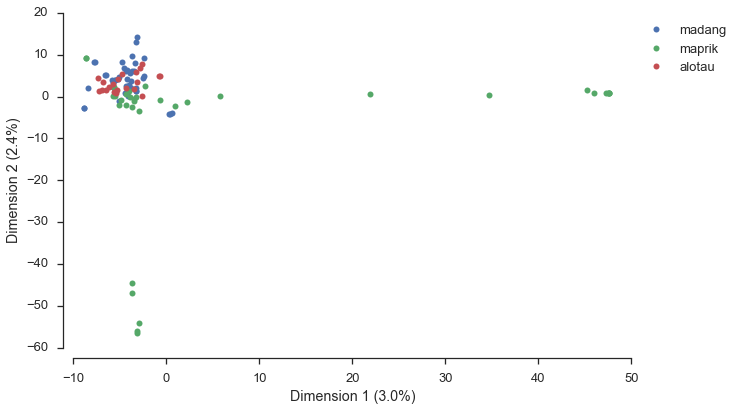

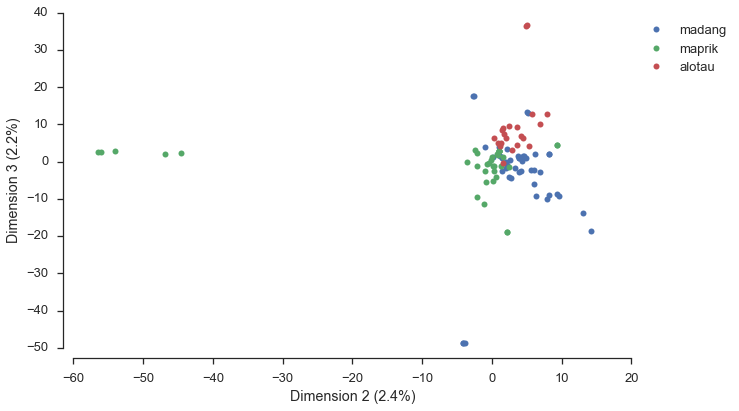

In [6]:
# select variants with a minor allele count > 2
pca_selection = (ac_subpops_merged['all'].max_allele() == 1) & (ac_subpops_merged['all'][:, :2].min(axis=1) > 2)
# print pca_selection
# filter first
gt_filter1 = gt_subpops_merged.take(np.nonzero(pca_selection)[0], axis = 0)
ld_variants  = allel.stats.ld.locate_unlinked(gt_filter1.to_n_alt()[:], size=100, step=20)
#print ld_variants
indices = np.nonzero(ld_variants)[0]
print "Variants in linkage equilibrium:", np.sum(ld_variants)

gt_subset = gt_filter1.take(indices, axis = 0)

gt_pca = gt_subset.to_n_alt()[:]
coords, model = allel.stats.decomposition.pca(gt_pca, scaler='standard')

pca_df = pd.DataFrame(coords, columns = ["PC" + str(i+1) for i in range(10)])
pca_df['Region'] = cohort_final['site']
pca_df['sample_id'] = cohort_final['sample_id']
pca_df.to_csv("cache/png_pca_results.txt", index = False)

variance = model.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(10, 6))
sns.despine(ax=ax, offset=10)
plot_mds(coords, variance, png_index, 0, 1, ax)
ax.legend( bbox_to_anchor=(1, 1), loc='upper left');


fig, ax = plt.subplots(figsize=(10, 6))
sns.despine(ax=ax, offset=10)
plot_mds(coords, variance, png_index, 1, 2, ax)
ax.legend( bbox_to_anchor=(1, 1), loc='upper left');

THe PCA analysis appears to give similar results as the PCoA - again we see that there is a gradient corresponding to geopgraphy and there are outlier samples in Maprik that are driving the variation. These samples are known to be imported infections to their locations.

The population structure observed in the MDS and PCA plots show that there is divergence along a geographical gradient where the largest difference is between the north coast and Milne Bay regions (and corroborated by the $F_{st}$ estimates of 0.08 between these sites.).

To search for within genome population differenation, we construct a sliding window estimator of $F_{st}$ accross each chromosome using blocks of 30 SNPs. 

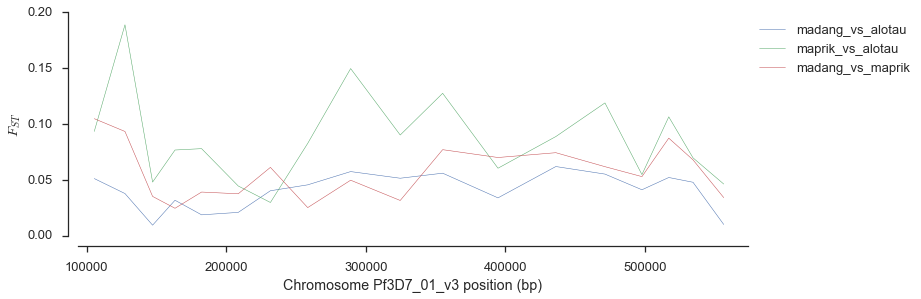

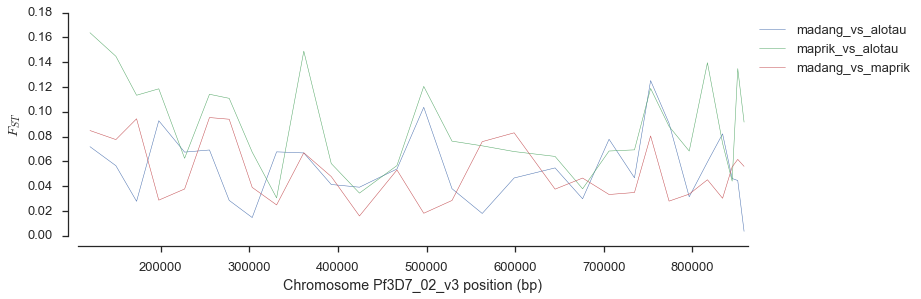

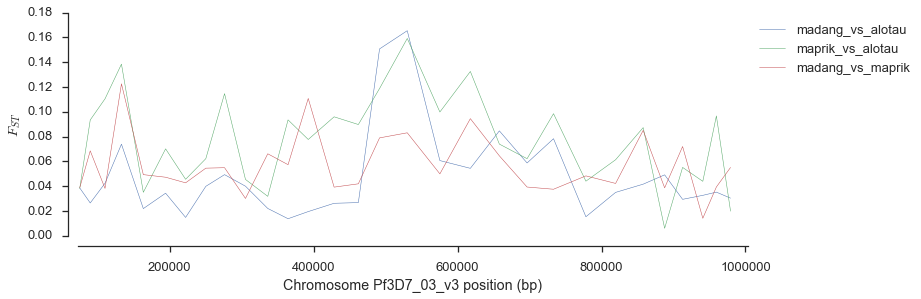

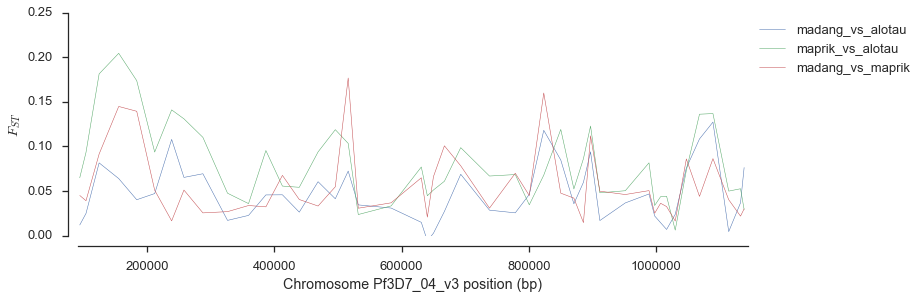

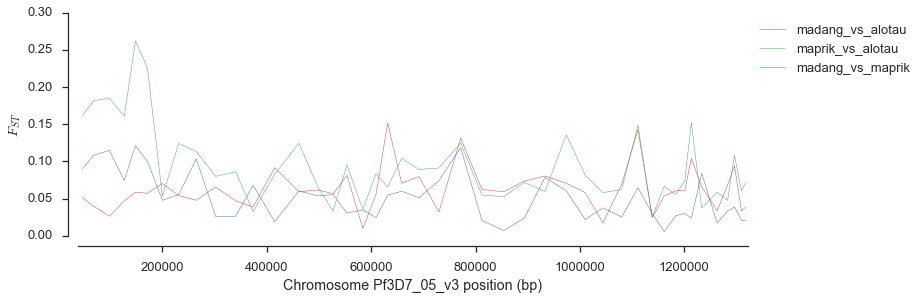

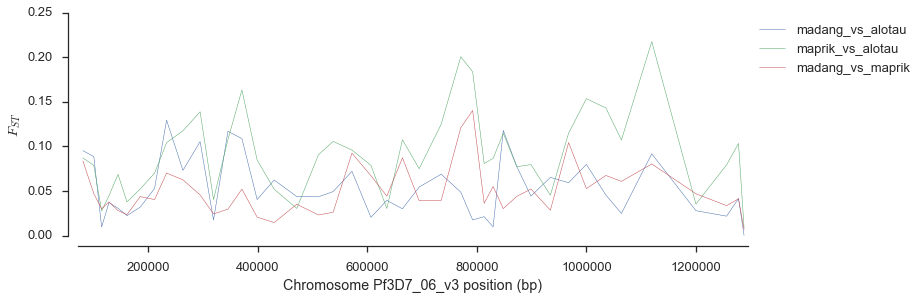

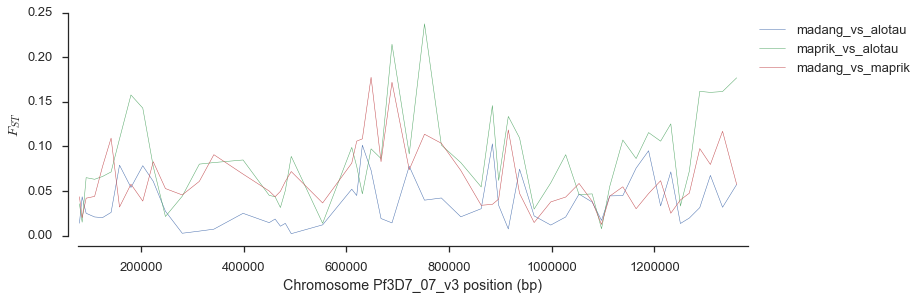

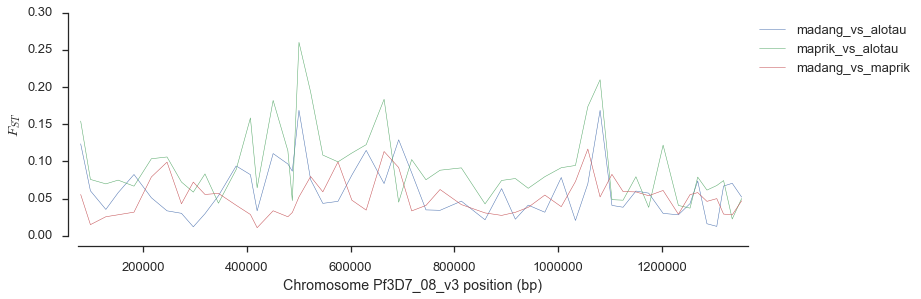

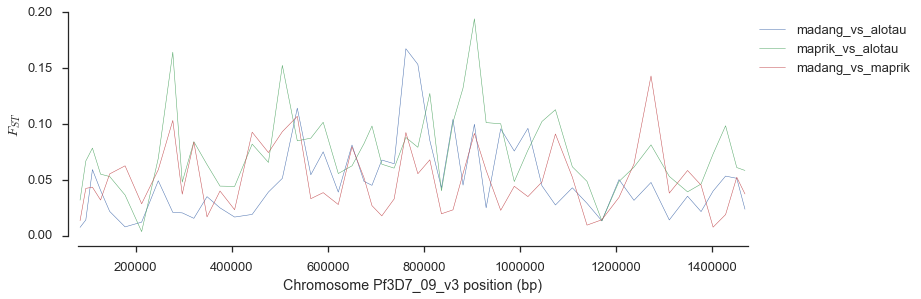

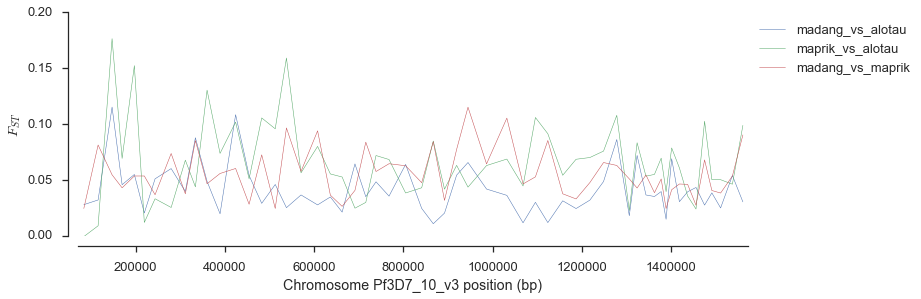

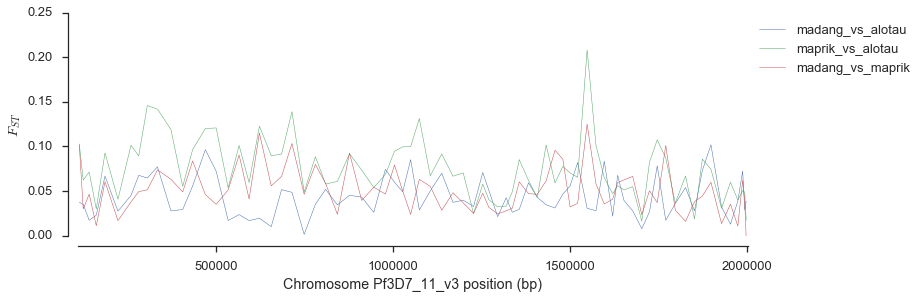

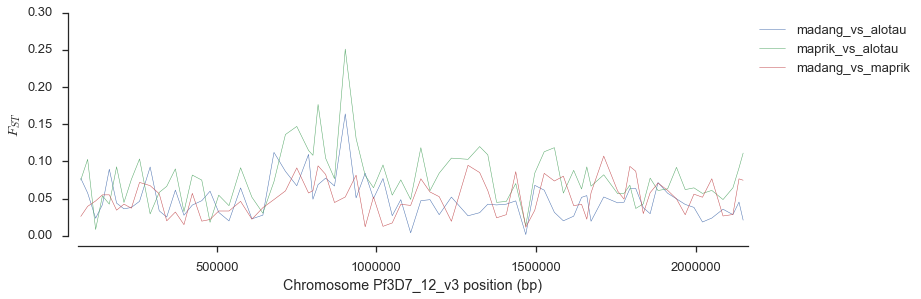

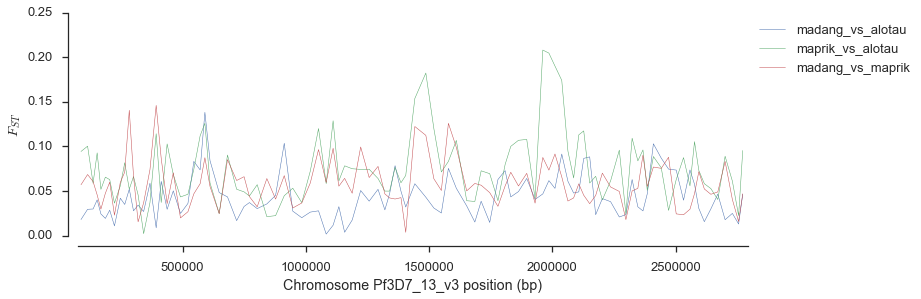

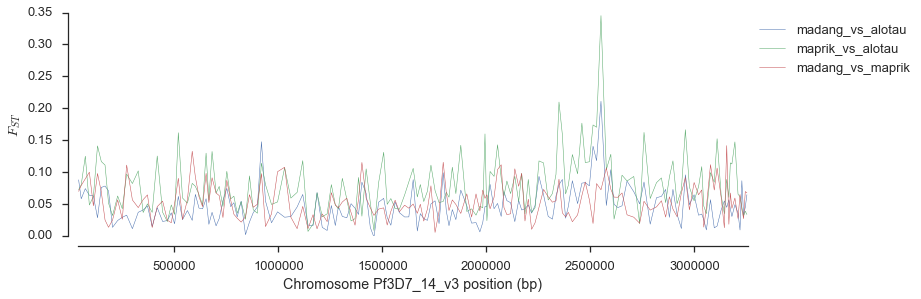

In [7]:
site_combos = itertools.combinations(sites, 2)
block_size = 30
# create dictionary to store results
fst_results = {}

for pairs in itertools.combinations(sites, 2):
    output_key = pairs[0] + "_vs_" + pairs[1]
    fst_results[output_key] = {'x': [], 'y': []}
    for i in range(len(ac_seg)):
        pos = positions[i]
        ac1 = ac_seg[i][pairs[0]]
        ac2 = ac_seg[i][pairs[1]]
        block_size = 30
        fst, se, vb, _ = allel.stats.blockwise_hudson_fst(ac1, ac2, blen=block_size)
        fst_results[output_key]['y'].append(vb)
        fst_results[output_key]['x'].append(allel.stats.moving_statistic(pos, 
                                                                         statistic=lambda v: (v[0] + v[-1]) / 2, 
                                                                         size=block_size))
# plot the results for each chromosome accross populations
for i in range(len(ac_seg)):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset = 10)
    for pairs in fst_results.keys():
        ax.plot(fst_results[pairs]['x'][i], fst_results[pairs]['y'][i], lw=.5, label= pairs)
    
    ax.set_ylabel('$F_{ST}$')
    ax.set_xlabel('Chromosome %s position (bp)' % chromosomes[i])
    ax.set_xlim(positions[i].min(), positions[i].max())
    ax.set_ylim(0, )
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1));   

We see that there is parts of the _P.falciparum_ genome that exhibit signals of differential selection in particular on chromosome 6, there appears to be to signals at 0.75Mb and 1.1Mb where there are differences between Maprik and the other groups. Similarly, there appears to be an Alotau driven signal on chromosome 14 at around 2.5Mb. Later we follow up to see what samples are driving these differences by excluding the outliers identified by the PCA/MDS analysis.

## Selection Analysis

Now that we have identified some population differences - we explore patterns of positive/negative and balancing selection within our populations of interest. First we construct estimates of Tajima's D using moving window of 30 SNPs within each chromosome.

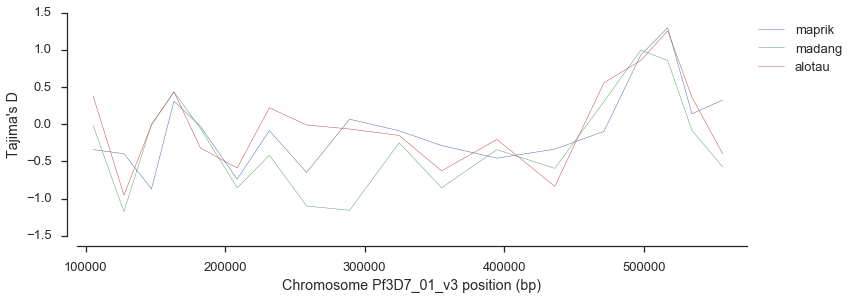

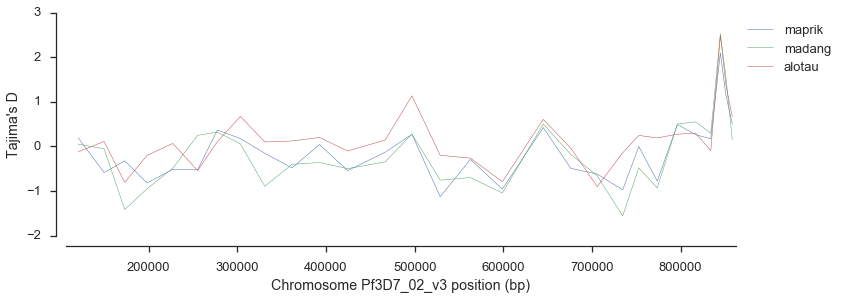

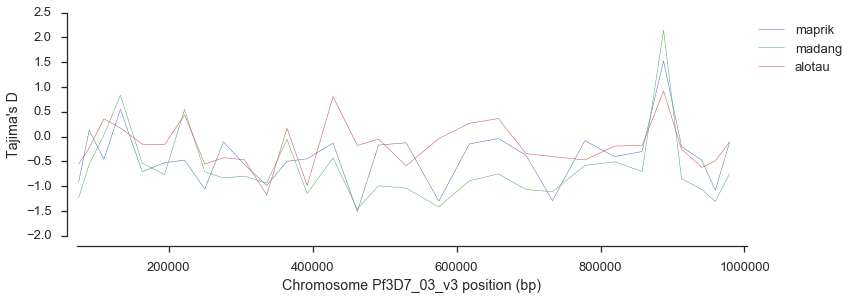

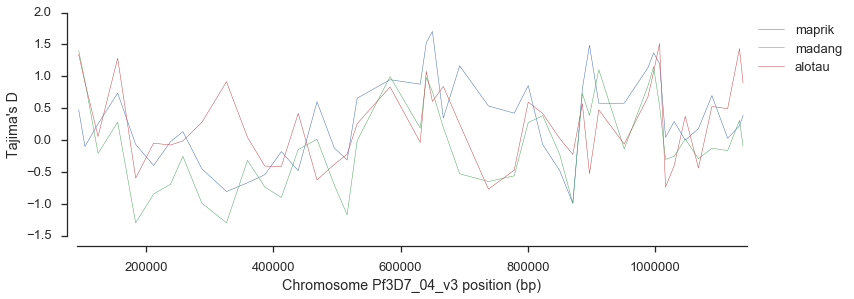

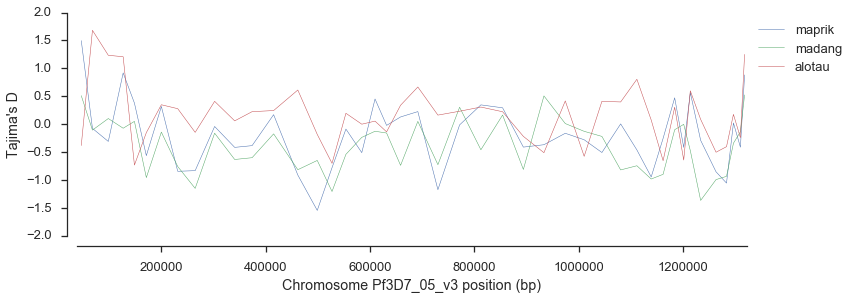

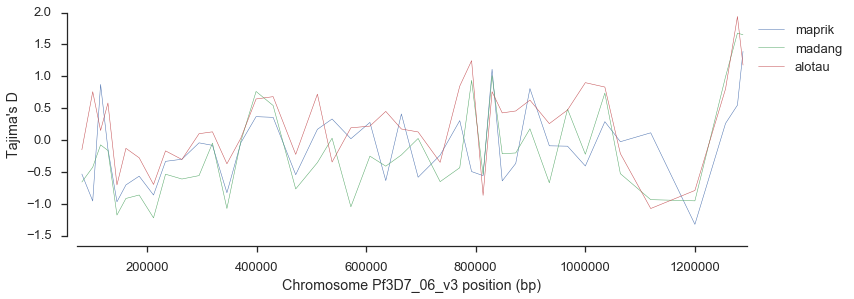

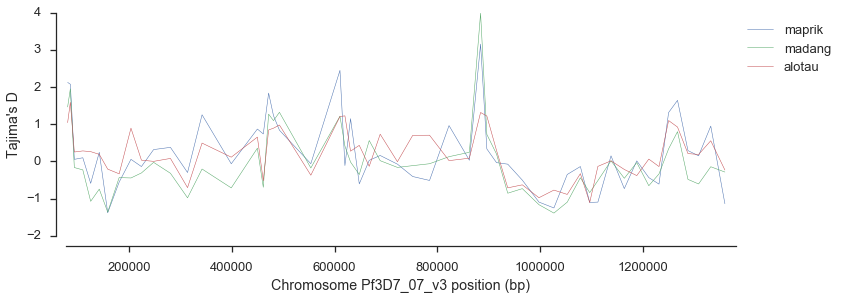

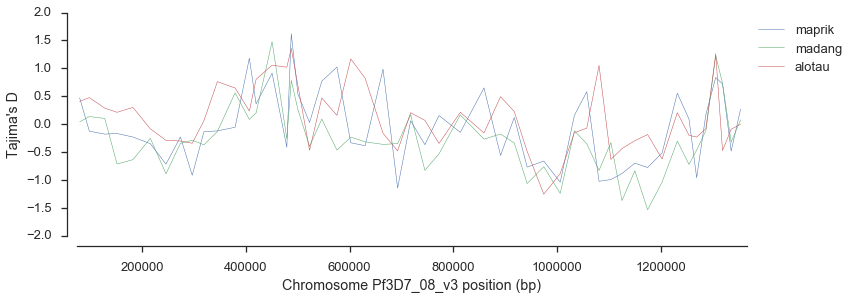

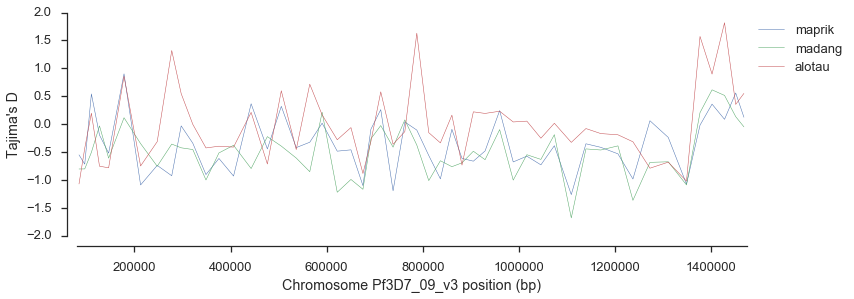

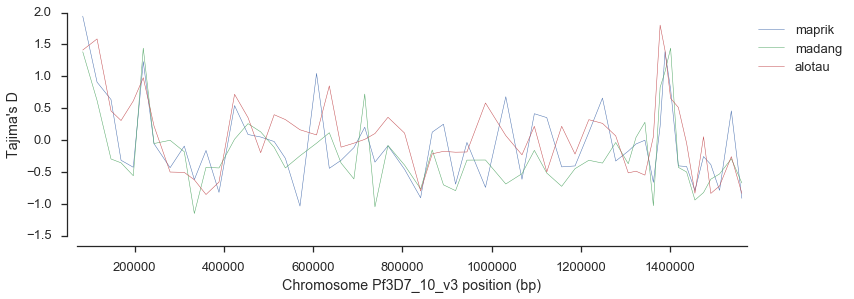

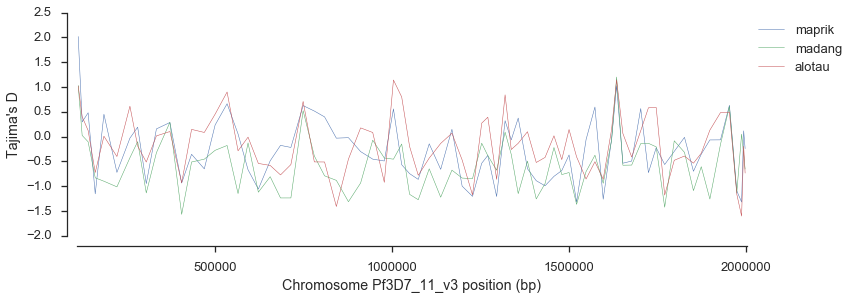

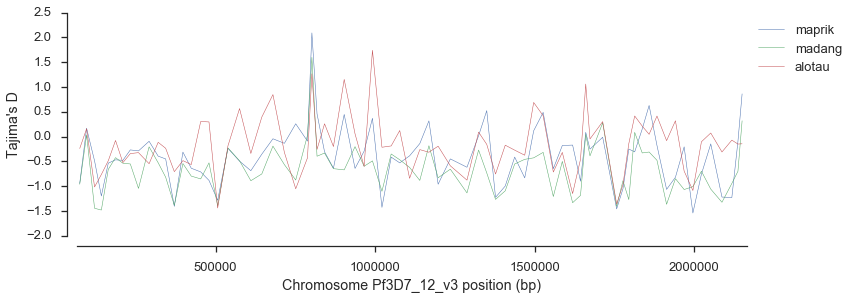

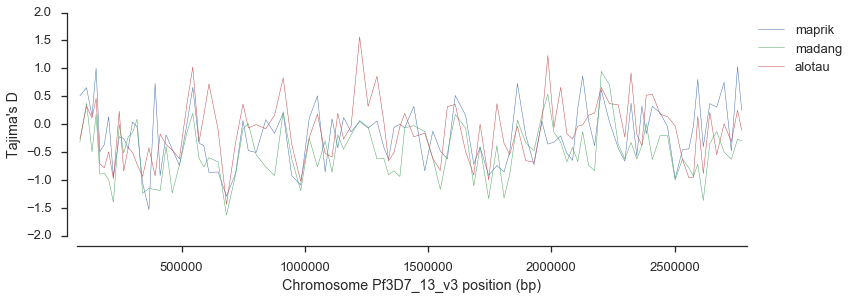

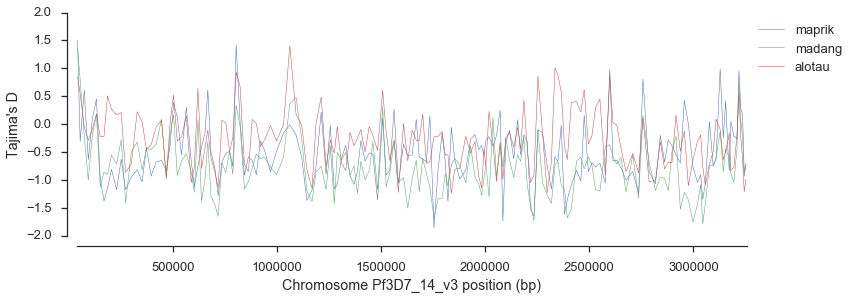

In [31]:
# assign a dict to store results for each pop
tjd_results = {}
sites = [key for key in png_index.keys() if key != 'all']
for output_key in sites:
    tjd_results[output_key] = {'x': [], 'y': []}
    for i in range(len(ac_seg)):
        pos = positions[i][:]
        min_pos = pos.min()
        max_pos = pos.max()
        windows = allel.stats.moving_statistic(pos, statistic=lambda v: [v[0], v[-1]], size=30)
        #print windows
        # midpoint of windows for plotting 
        # print output_key
        ac_in = ac_seg[i][output_key][:]
        
        y,_, _ = allel.stats.windowed_tajima_d(pos, ac_in, windows = windows)
        #print windows
        midpoint = np.asarray(windows).mean(axis=1)
        tjd_results[output_key]['x'].append(midpoint)
        tjd_results[output_key]['y'].append(y)


for i in range(len(ac_seg)):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset = 10)
    for sites in tjd_results.keys():
        ax.plot(tjd_results[sites]['x'][i], tjd_results[sites]['y'][i], lw=.5, label= sites)
    
    ax.set_ylabel("Tajima's D")
    ax.set_xlabel('Chromosome %s position (bp)' % chromosomes[i])
    ax.set_xlim(positions[i].min(), positions[i].max())
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1));   

There appears to be a strong signal of balancing selection on chromosome 7 - overlapping the _pfcrt_ locus. To assess the significance of signals we collapse all windows and D values and plot the empiriical cumululative distributions of scores. 

Next we compute the iHS within each population using the following steps:

1. Generate haplotypes for each sampling site
2. Exclude SNPs if their MAF is less than 0.01
3. Compute the iHS over all remaining SNPs
4. Normalise iHS by subtracting the mean and standard deviation of the genome wide distributions binning over allele frequencies.


In [40]:
haplotypes_subset = {}
ihs_out = {}
# subset haplotypes by sample ID 
sites = [key for key in png_index.keys() if key != 'all']
for pops in sites:
    keep_snps = [np.where(ac_seg[i]['all'].to_frequencies()[:, (0,1)].min(axis=1) > 0.01) 
                     for i in range(len(ac_seg))]
    pos_kept = [positions[i][keep_snps[i]] for i in range(len(keep_snps))]
    # compute minor allele frequences for each SNP and get indexes where MAF > 0.01
    gt_subset = [genotypes_seg[i].subset(sel0 = keep_snps[i], sel1 = png_index[pops]) 
                 for i in range(len(genotypes_seg))]
    haplotypes_subset[pops] = [gt_subset[i].to_haplotypes()[:] for i in range(len(gt_subset))]
        
    ihs_out[pops] = [allel.stats.selection.ihs(haplotypes_subset[pops][i], pos_kept[i], min_ehh = None) 
                         for i in range(len(gt_subset))]

# compute allele frequency bins
raf_bins = np.linspace(0.01, 1, 100)
rafs = [ac_seg[i]['all'].to_frequencies()[:,0] for i in range(len(ac_seg))]

# create pandas data frame
ihs_all = {'chrom': np.hstack([variants_seg[i]['CHROM'][:][keep_snps[i]] for i in range(len(variants_seg))]),
           'pos': np.hstack([variants_seg[i]['POS'][:][keep_snps[i]] for i in range(len(variants_seg))]),
           'raf': np.hstack([rafs[i][keep_snps[i]] for i in range(len(rafs))])}

for pops in sites:
    col_name = pops + "_raw_ihs"
    ihs_all[col_name] = np.hstack(ihs_out[pops])


ihs_all = pd.DataFrame(ihs_all)

ihs_all['bins'] = pd.cut(ihs_all['raf'], raf_bins)
# loop over and bin by raf
for pops in sites:
    new_col = pops + "_norm_ihs"
    ihs_all[new_col] = ihs_all.groupby(['bins'])[pops+"_raw_ihs"].apply(lambda x: (x - np.nanmean(x)) / (np.nanstd(x)))

ihs_all.head(n=10)

,alotau_raw_ihs,chrom,madang_raw_ihs,maprik_raw_ihs,pos,raf,bins,madang_norm_ihs,maprik_norm_ihs,alotau_norm_ihs
0,1.727755,Pf3D7_01_v3,NaN,NaN,93824,0.961957,"(0.96, 0.97]",NaN,NaN,-0.529477
1,NaN,Pf3D7_01_v3,3.603085,1.722647,94044,0.954545,"(0.95, 0.96]",1.332411,-0.196362,NaN
2,NaN,Pf3D7_01_v3,2.812749,2.543870,94976,0.969697,"(0.96, 0.97]",0.248587,0.632696,NaN
3,3.093968,Pf3D7_01_v3,1.132644,1.051417,95839,0.826087,"(0.82, 0.83]",-0.440417,-0.161006,1.866955
4,1.458835,Pf3D7_01_v3,2.361223,2.530500,96128,0.918367,"(0.91, 0.92]",0.433828,0.953504,-0.572493
5,1.458835,Pf3D7_01_v3,2.369896,2.530500,96136,0.917526,"(0.91, 0.92]",0.445180,0.953504,-0.572493
6,1.198723,Pf3D7_01_v3,0.862204,-0.007564,97100,0.775510,"(0.77, 0.78]",-0.466539,-1.030233,-0.106975
7,2.082412,Pf3D7_01_v3,NaN,NaN,97387,0.969072,"(0.96, 0.97]",NaN,NaN,-0.188353
8,2.082412,Pf3D7_01_v3,NaN,NaN,97718,0.969697,"(0.96, 0.97]",NaN,NaN,-0.188353
9,2.527413,Pf3D7_01_v3,NaN,NaN,98042,0.970000,"(0.96, 0.97]",NaN,NaN,0.239667


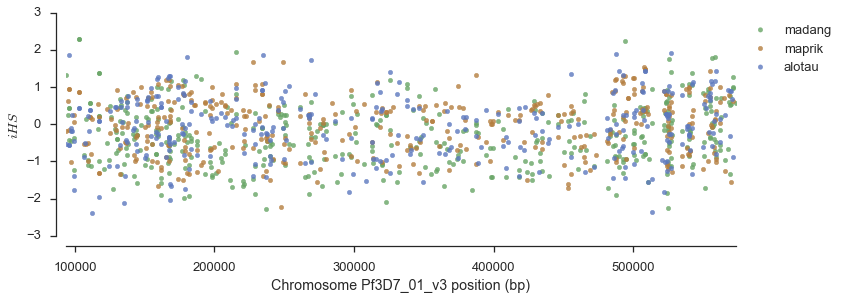

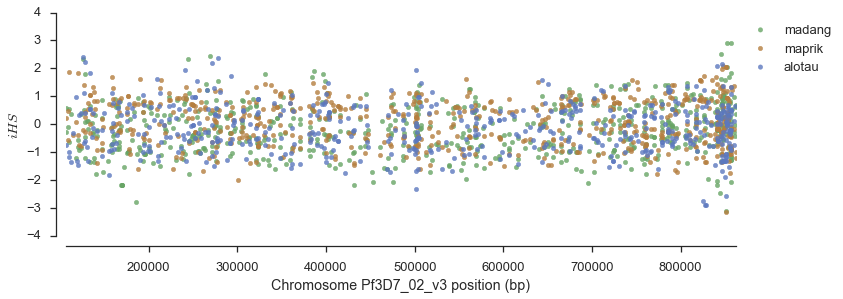

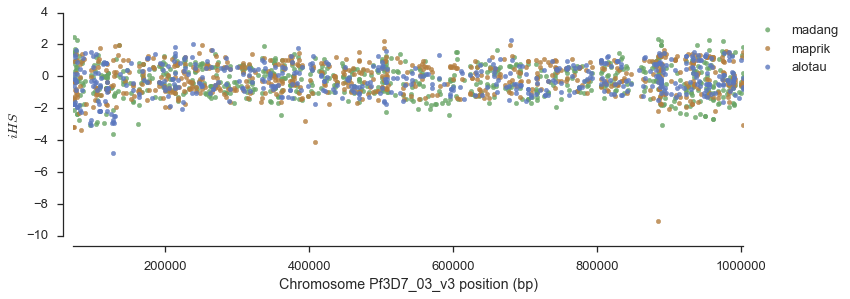

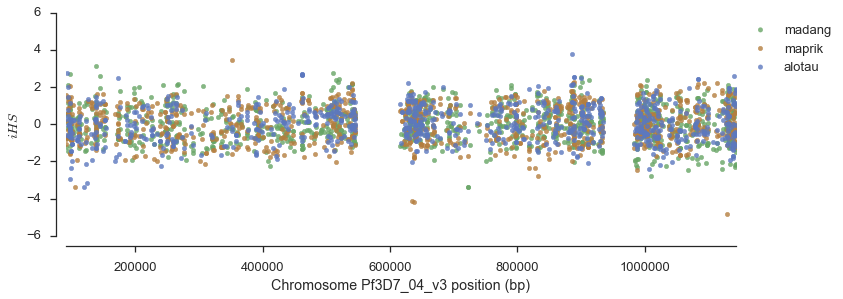

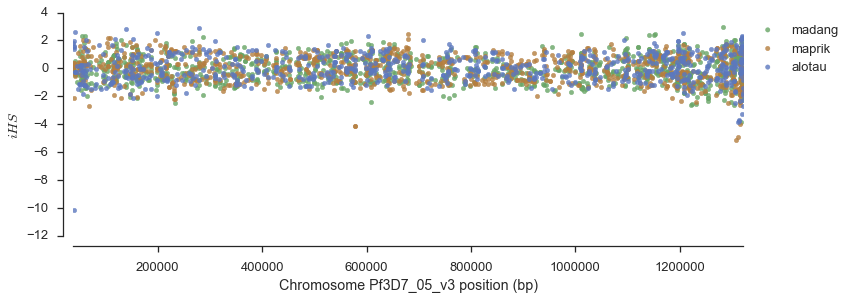

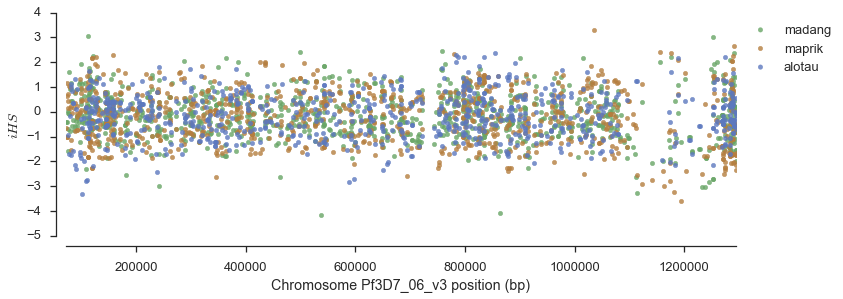

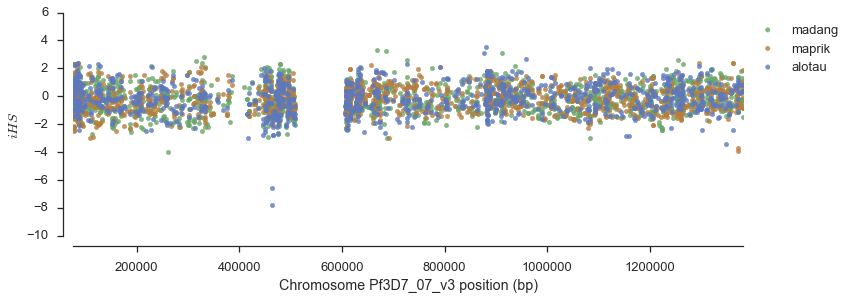

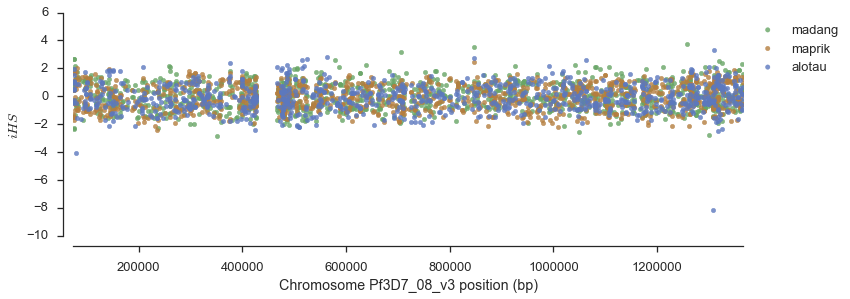

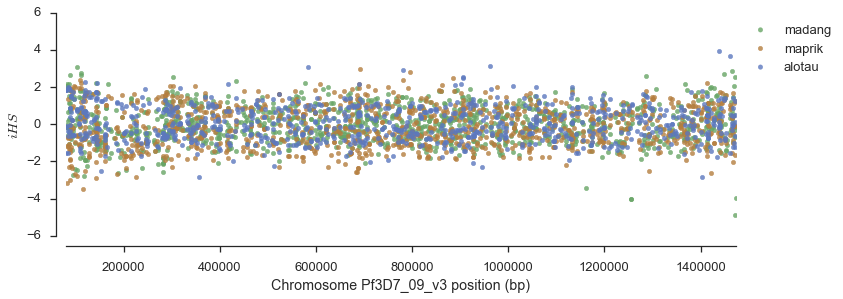

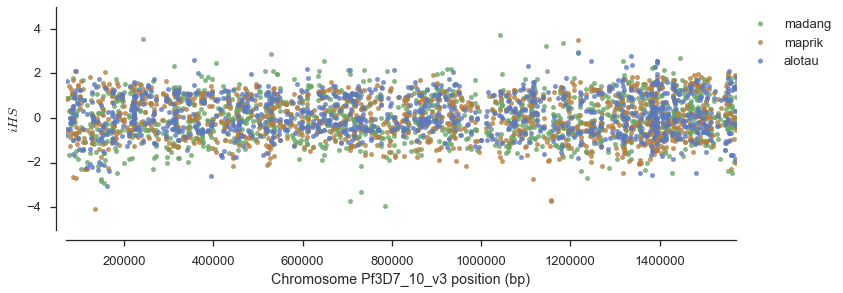

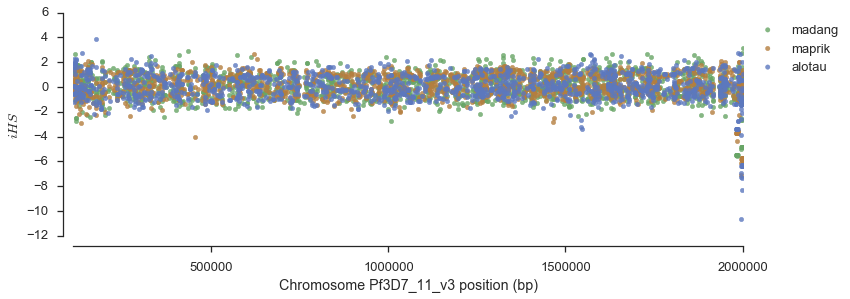

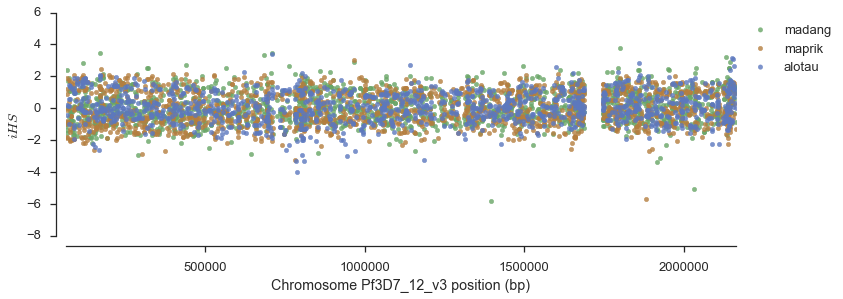

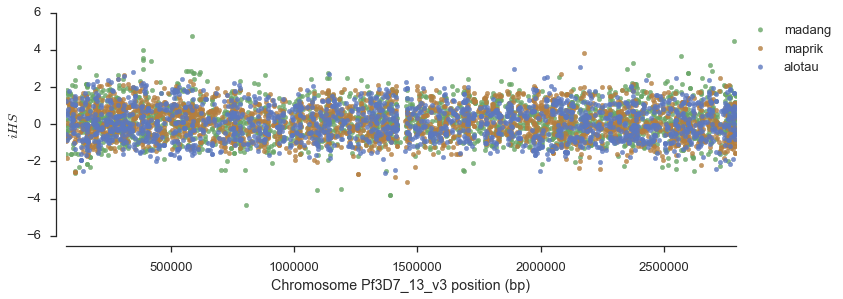

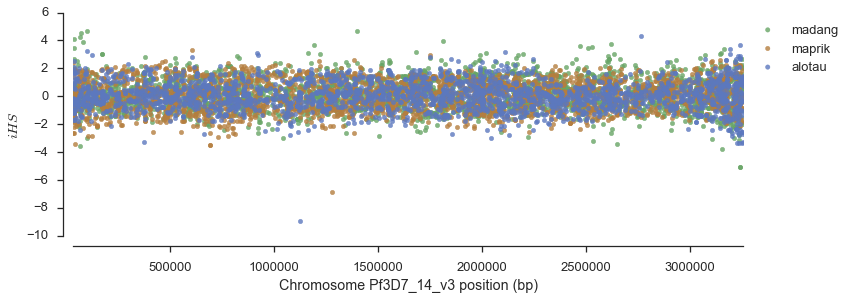

In [46]:
colors = {'madang': "#68a566", 'alotau':"#5c78bf", 'maprik':"#b57e3f"}
for chrom in pd.unique(ihs_all['chrom']):
    chrom_df = ihs_all[ihs_all['chrom'] == chrom]
    
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset=10)
    for pops in png_index.keys():
        
        if pops != 'all':
            ax.scatter(chrom_df['pos'], chrom_df[pops+'_norm_ihs'], label = pops, alpha = 0.8, color = colors[pops])
    ax.set_ylabel("$iHS$")
    ax.set_xlabel('Chromosome %s position (bp)' % chrom )
    ax.set_xlim(chrom_df['pos'].min(), chrom_df['pos'].max())
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1));

To find variants that appear to be under a selective sweep we look at the qqplots of each site genome-wide. We use the a standard Gaussian as the reference distribution

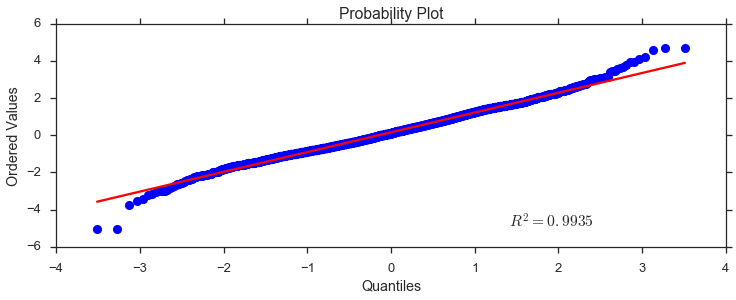

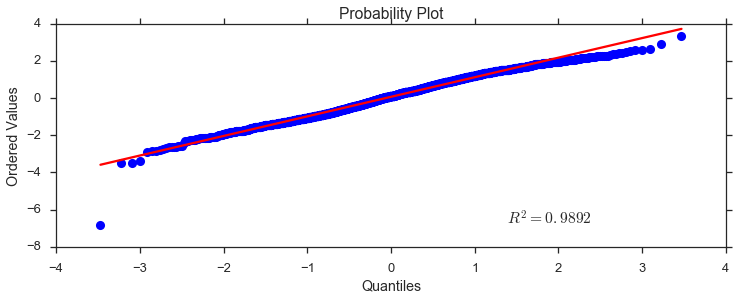

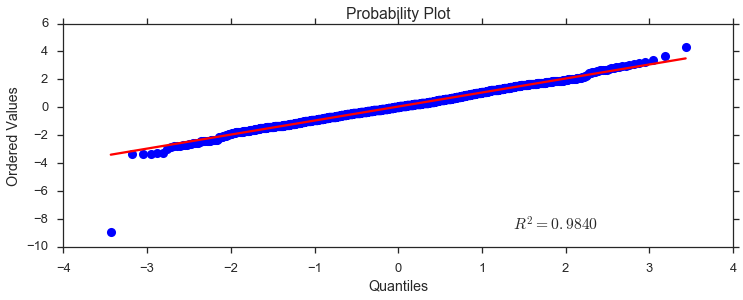

In [67]:
for keys in [e for e in png_index.keys() if e != 'all']:
    plt.subplots(figsize=(12, 4))
    x,y = stats.probplot(chrom_df[keys+'_norm_ihs'].dropna(), dist="norm", plot=plt)


The iHS values we computed need to be normalised - we do this by binning the variants by reference allele frequency then substracting the genome-wide mean iHS and dividing by the genome-wide standard devation of the iHS.

After standardising the iHS values by reference allele frequency we plot the results by chromosome.

Next we compute the unstandardised XP-EHH values within each chromosome. Currently not working :(

In [37]:
xpehh_out = []
for i in range(len(haplotypes)):
    hap1 = allel.HaplotypeArray(haplotypes[i].subset(sel1 = ca_subpops['malawi']))
    hap2 = allel.HaplotypeArray(haplotypes[i].subset(sel1 = ca_subpops['dr_of_the_congo']))
    positions = variants_seg[i]['POS'][:]
    xpehh_out.append(allel.stats.selection.xpehh(hap1, hap2, positions, min_ehh = None))
                                         


TypeError: 'int' object is unsliceable

## TODO

* Update XPEHH analysis once bug in scikit.allel is fixed.
* Gather top-hits from Lyndal's analysis and check overlaps between her hits and the hits obtained from iHS.

